# Detect object count from bin image

**TODO**: Give a helpful introduction to what this notebook is for. Remember that comments, explanations and good documentation make your project informative and professional.

In this project, we will train a computer vision CNN model with images from the 'Amazon Bin Image Dataset', and deploy the model, so we can call the inference endpoint, to predict the number of objects given an input bin image.

**Note:** This notebook has a bunch of code and markdown cells with TODOs that you have to complete. These are meant to be helpful guidelines for you to finish your project while meeting the requirements in the project rubrics. Feel free to change the order of the TODO's and/or use more than one cell to complete all the tasks.

In [ ]:
# TODO: Install any packages that you might need

#!pip install smdebug

In [1]:
# TODO: Import any packages that you might need

import os
import json
import time
import boto3
from tqdm import tqdm
from PIL import Image, ImageFilter
#import IPython
#from IPython import display

import numpy as np

import matplotlib.pyplot as plt
#from mpl_toolkits.axes_grid1 import host_subplot

import sagemaker
from sagemaker import get_execution_role
from sagemaker.predictor import Predictor
from sagemaker.pytorch import PyTorch, PyTorchModel, PyTorchPredictor
from sagemaker.tuner import ContinuousParameter, CategoricalParameter, IntegerParameter, HyperparameterTuner
from sagemaker.serializers import IdentitySerializer
from sagemaker.deserializers import JSONDeserializer

#from smdebug.trials import create_trial
#from smdebug.core.modes import ModeKeys

%matplotlib inline

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml


## Data Preparation
**TODO:** Run the cell below to download the data.

The cell below creates a folder called `bin_images`, downloads training and testing data and arranges them in subfolders. 

Each of these subfolders contain images where the number of objects is equal to the name of the folder. For instance, all images in folder `1` has images with 1 object in them. 

Images will be divided into training, validation and testing sets. 

I should mention this JSON metadata file `file_list.json` provided by the starter repo is very helpful, because it has gone thru a subset of metadata JSON files in the source dataset, read the attribute `EXPECTED_QUANTITY` of each JSON file, and built a dict like this:

```
{
    "1": ["data/metadata/100313.json", "data/metadata/09915.json", ...],
    "2": ["data/metadata/102489.json", "data/metadata/104982.json", ...],
    "3": ["data/metadata/04031.json", "data/metadata/04749.json", ...],
    "4": ["data/metadata/101042.json", "data/metadata/09753.json", ...],
    "5": ["data/metadata/03858.json", "data/metadata/101598.json", ...],
}
```

Note that `file_list.json` (and hence this project) only includes images of object counts from 1 to 5. 

Official documentation of the source dataset: 

https://registry.opendata.aws/amazon-bin-imagery/

In [6]:
def download_and_arrange_data():

    s3_client = boto3.client('s3')

    with open('file_list.json', 'r') as f:
        d=json.load(f)

    data_distribution={
        'train': {},
        'valid': {},
        'test': {}
    }

    for k, v in d.items():
        total=len(v)
        print(f"Downloading '{total}' images with '{k}' objects...")

        # split the data into 3 sets: 80% train, 10% validation, 10% test
        new_v = {}
        train_set_size = int(total * 0.8)
        new_v['train'] = v[0:train_set_size]
        val_set_size = int(total * 0.1)
        val_set_upper_index = train_set_size + val_set_size
        new_v['valid'] = v[train_set_size:val_set_upper_index]
        new_v['test'] = v[val_set_upper_index:]
        test_set_size = len(new_v['test'])

        for set_type in ['train', 'valid', 'test']:

            directory=os.path.join('bin_images', set_type, k)
            if not os.path.exists(directory):
                os.makedirs(directory)

            data_distribution[set_type][k] = len(new_v[set_type])

            for file_path in tqdm(new_v[set_type]): # 'data/metadata/100313.json'
                file_name=os.path.basename(file_path).split('.')[0]+'.jpg' # '100313.jpg'
                s3_client.download_file('aft-vbi-pds', os.path.join('bin-images', file_name), os.path.join(directory, file_name))

    print("Finished downloading a subset from 'Amazon Bin Image Dataset' for our project!")

    return data_distribution

In [7]:
data_distribution = download_and_arrange_data()

print('Downloaded data distribution:')
print(json.dumps(data_distribution, indent=4, sort_keys=True))

100%|██████████| 124/124 [00:10<00:00, 11.73it/s]


100%|██████████| 231/231 [00:19<00:00, 11.71it/s]


100%|██████████| 268/268 [00:23<00:00, 11.17it/s]


100%|██████████| 238/238 [00:21<00:00, 11.03it/s]


100%|██████████| 188/188 [00:15<00:00, 12.08it/s]

Finished downloading a subset from 'Amazon Bin Image Dataset' for our project!
Downloaded data distribution:
{
    "test": {
        "1": 124,
        "2": 231,
        "3": 268,
        "4": 238,
        "5": 188
    },
    "train": {
        "1": 982,
        "2": 1839,
        "3": 2132,
        "4": 1898,
        "5": 1500
    },
    "valid": {
        "1": 122,
        "2": 229,
        "3": 266,
        "4": 237,
        "5": 187
    }
}


## Dataset

**TODO:** Explain what dataset you are using for this project. Give a small overview of the classes, class distributions etc that can help anyone not familiar with the dataset get a better understanding of it. You can find more information about the data [here](https://registry.opendata.aws/amazon-bin-imagery/).

bin images include images of bins having from 1 to 5 objects inside, so there are 5 classes.

`file_list.json` has given us a subset of 10,441 images from the >500,000 images in the source dataset, we have split this subset further to 3 datasets for our training and testing.

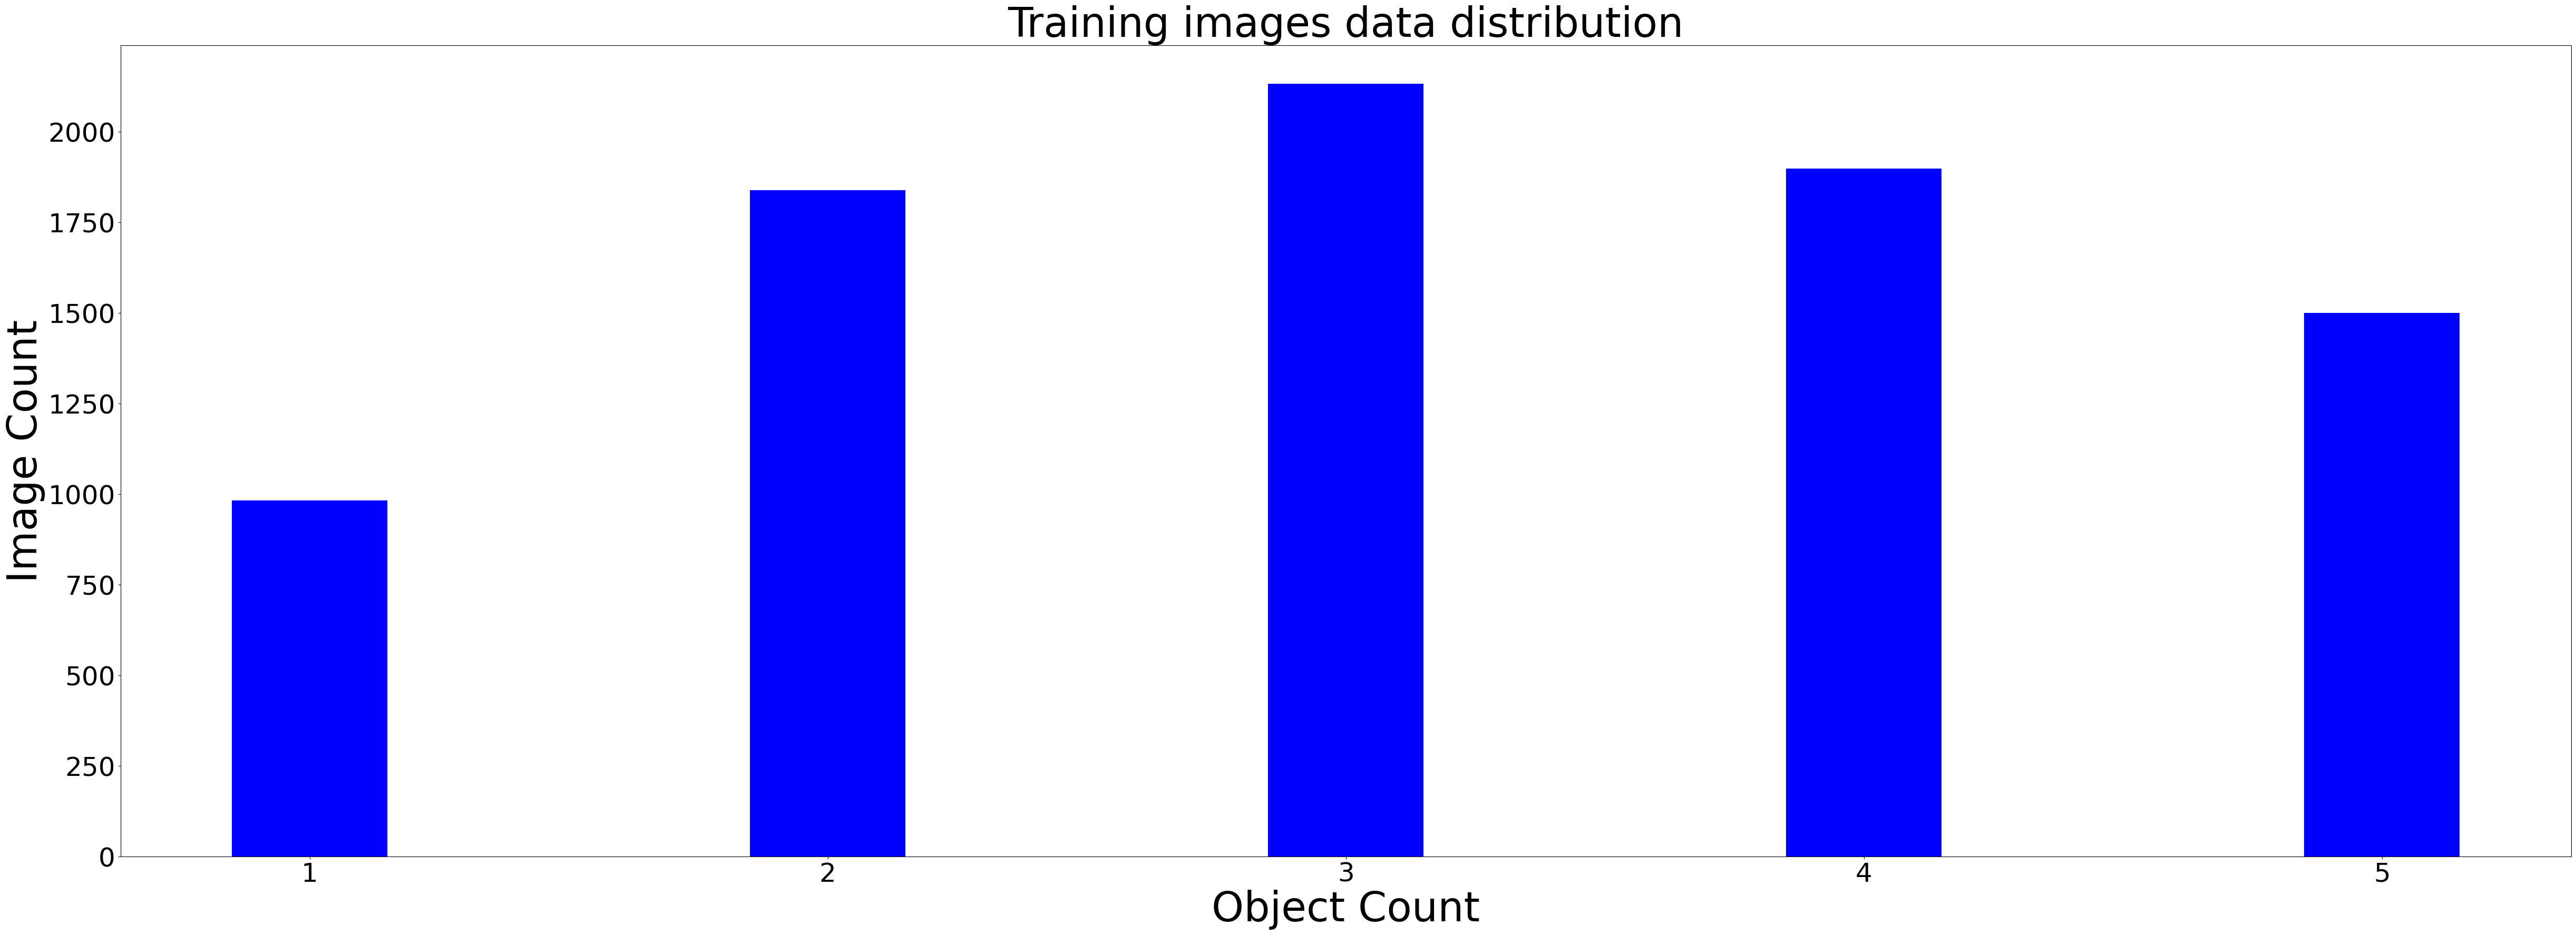

In [21]:
# show training image distribution in a bar graph

fontsize = 56

y = list(data_distribution['train'].values())
x = list(data_distribution['train'].keys())

plt.figure(figsize=(60,20))

plt.bar(x, y, color='blue', width=0.3)

plt.title('Training images data distribution', fontsize=fontsize)
plt.xlabel('Object Count', fontsize=fontsize)
plt.ylabel('Image Count', fontsize=fontsize)
plt.tick_params(axis="both", labelsize=36)

plt.show()

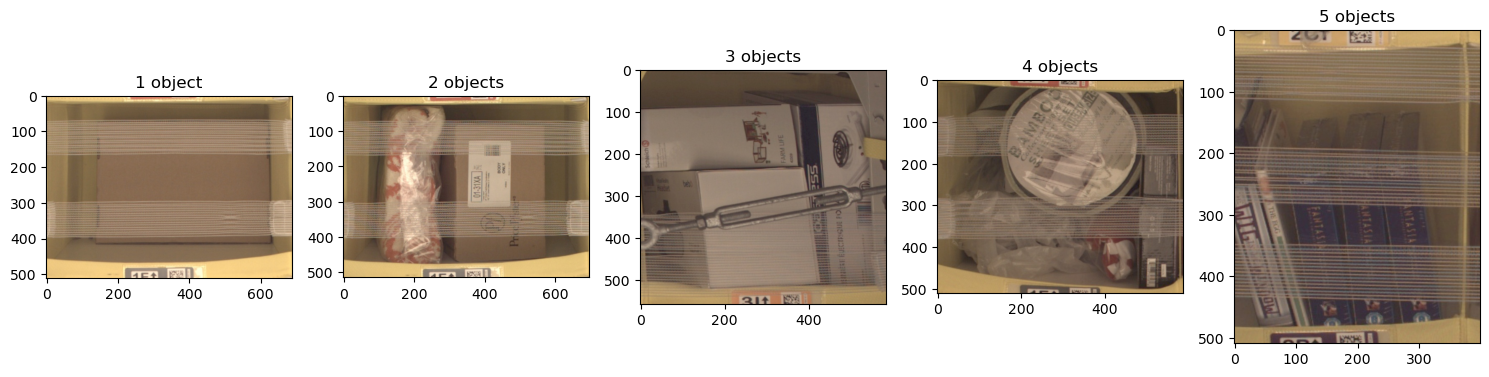

In [29]:
# show example image

import matplotlib.image as mpimg

def show_image(file_path, title=''):
    image = Image.open(file_path) # return a JpegImageFile object

    width, height = image.size
    file_name = os.path.basename(file_path)
    print(f"'{file_name}' has size {width} x {height} pixels")

    plt.title(title)
    plt.imshow(image)

#show_image('bin_images/train/1/00035.jpg', 'Sample image of a bin with 1 object')
#show_image('bin_images/train/2/00036.jpg', 'Sample image of a bin with 2 objects')
#show_image('bin_images/train/3/00039.jpg', 'Sample image of a bin with 3 objects')
#show_image('bin_images/train/4/08973.jpg', 'Sample image of a bin with 4 objects')
#show_image('bin_images/train/5/00019.jpg', 'Sample image of a bin with 5 objects')

image_paths = [
    'bin_images/train/1/00035.jpg',
    'bin_images/train/2/00036.jpg',
    'bin_images/train/3/00039.jpg',
    'bin_images/train/4/08973.jpg',
    'bin_images/train/5/00019.jpg'
]

titles = [
    '1 object',
    '2 objects',
    '3 objects',
    '4 objects',
    '5 objects'
]

fig, axes = plt.subplots(1, 5, figsize=(15, 5))

for i, ax in enumerate(axes):
    # Read and display each image
    img = mpimg.imread(image_paths[i])
    ax.imshow(img)

    # Set the title for each image
    ax.set_title(titles[i])

plt.tight_layout()
plt.show()

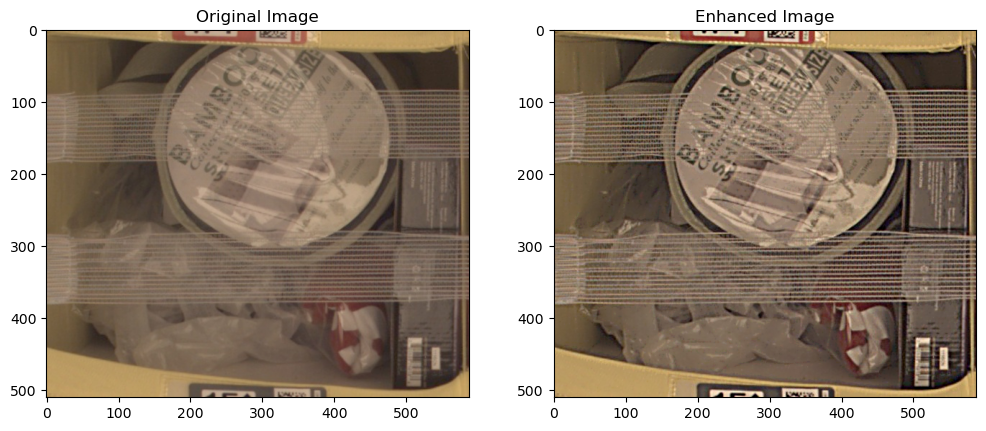

In [33]:
#TODO: Perform any data cleaning or data preprocessing

# a lot of images look blurry, see if we can enhance them...

def sharpen_image(file_path):
    image = Image.open(file_path)
    # radius: size of edges to be enhanced
    # percent: unsharp strengh, how much contrast to add at the edges
    # threshold: min brightness change that will be sharpened
    return image, image.filter(ImageFilter.UnsharpMask(radius=4, percent=150, threshold=3))

def show_images_side_by_side(image1, title1, image2, title2):
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.title(title1)
    plt.imshow(image1)

    plt.subplot(1, 2, 2)
    plt.title(title2)
    plt.imshow(image2)

    plt.show()

image, enhanced_image = sharpen_image('bin_images/train/4/08973.jpg')
#image, enhanced_image = sharpen_image('bin_images/train/3/00039.jpg')

show_images_side_by_side(image, 'Original Image', enhanced_image, 'Enhanced Image')

In [36]:
# enhance the images before uploading them to S3

dir_name = 'bin_images'
new_dir_name = 'enhanced_bin_images'

for set_type in os.listdir(dir_name):
    if set_type == '.DS_Store':
        continue

    for object_count in os.listdir(os.path.join(dir_name, set_type)):
        if object_count == '.DS_Store':
            continue

        directory = os.path.join(new_dir_name, set_type, object_count)
        if not os.path.exists(directory):
            os.makedirs(directory)

        for file_name in os.listdir(os.path.join(dir_name, set_type, object_count)):
            if file_name == '.DS_Store':
                continue

            image, enhanced_image = sharpen_image(os.path.join(dir_name, set_type, object_count, file_name))

            enhanced_image.save(os.path.join(directory, file_name))

print(f"Enhanced images and saved them to '{new_dir_name}'")

Enhanced images and saved them to 'enhanced_bin_images'


In [38]:
# before uploading images to S3, i want to check torchvision data loader stuff

import io
import torch
from torchvision import datasets, transforms

train_transforms = transforms.Compose([
            transforms.RandomResizedCrop(224),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
train_image_folder = datasets.ImageFolder('enhanced_bin_images/train', train_transforms)
train_data_loader = torch.utils.data.DataLoader(train_image_folder, batch_size=2, shuffle=True, num_workers=2)

In [39]:
# check the first batch

for inputs, targets in train_data_loader:
    break

In [40]:
targets

tensor([0, 3])

In [41]:
inputs

tensor([[[[ 1.0159,  0.9646,  0.9303,  ...,  1.3413,  1.4954,  1.6324],
          [ 1.2214,  1.2043,  1.1187,  ...,  1.6153,  1.6667,  1.7352],
          [ 1.3413,  1.3927,  1.4098,  ...,  1.4612,  1.4612,  1.4783],
          ...,
          [ 1.0673,  1.0673,  1.0502,  ...,  1.7009,  1.5810,  1.4440],
          [ 1.0844,  1.0673,  1.0502,  ...,  1.1015,  0.9132,  0.7077],
          [ 1.0844,  1.0502,  1.0159,  ...,  0.0398, -0.1143, -0.3369]],

         [[ 0.6078,  0.5553,  0.5203,  ...,  0.8179,  0.9755,  1.1155],
          [ 0.8354,  0.8179,  0.7304,  ...,  1.2031,  1.2731,  1.3256],
          [ 0.9580,  1.0280,  1.0280,  ...,  1.1331,  1.1331,  1.1506],
          ...,
          [ 0.6954,  0.6954,  0.6779,  ...,  1.1681,  1.0980,  0.9580],
          [ 0.7129,  0.6954,  0.6779,  ...,  0.6954,  0.5553,  0.3627],
          [ 0.7129,  0.6779,  0.6429,  ..., -0.2325, -0.3550, -0.5126]],

         [[-0.1661, -0.2184, -0.2532,  ...,  0.0953,  0.2522,  0.3916],
          [ 0.0256, -0.0092, -

In [42]:
# jumping ahead to inference time...

# we send image bytes to inference endpoint
with open('enhanced_bin_images/train/1/100313.jpg', 'rb') as f:
    image_bytes = f.read()

# custom input_fn convert to jpeg file    
input = Image.open(io.BytesIO(image_bytes))

# custom predict_fn make the same transforms during training and validation
val_transforms = transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
transformed_input = val_transforms(input)

transformed_input

tensor([[[-0.2856, -0.2684, -0.2856,  ...,  0.0569,  0.0741,  0.1083],
         [ 0.1083,  0.0912,  0.0569,  ..., -0.2171, -0.1999, -0.1657],
         [ 0.3309,  0.2967,  0.2624,  ..., -0.1486, -0.1486, -0.1314],
         ...,
         [ 2.0948,  2.0948,  2.0777,  ...,  2.0092,  2.0092,  2.0092],
         [ 2.0948,  2.0948,  2.1119,  ...,  2.0263,  2.0263,  2.0092],
         [ 2.0777,  2.1119,  2.1290,  ...,  2.0605,  2.0434,  2.0092]],

        [[-0.6176, -0.6001, -0.5826,  ..., -0.2675, -0.2500, -0.2150],
         [-0.2150, -0.2325, -0.2325,  ..., -0.5126, -0.4951, -0.4776],
         [ 0.0126, -0.0224, -0.0399,  ..., -0.4251, -0.4251, -0.4251],
         ...,
         [ 1.5882,  1.5882,  1.5707,  ...,  1.4657,  1.4657,  1.4657],
         [ 1.5882,  1.5882,  1.6057,  ...,  1.5007,  1.5007,  1.4832],
         [ 1.5707,  1.6057,  1.6232,  ...,  1.5357,  1.5182,  1.4832]],

        [[-0.7936, -0.7761, -0.7761,  ..., -0.6715, -0.6541, -0.6193],
         [-0.4275, -0.4275, -0.4450,  ..., -0

In [43]:
# to match with that from data loader, we need to add a dimension

ready_input = transformed_input.unsqueeze(0)

ready_input

tensor([[[[-0.2856, -0.2684, -0.2856,  ...,  0.0569,  0.0741,  0.1083],
          [ 0.1083,  0.0912,  0.0569,  ..., -0.2171, -0.1999, -0.1657],
          [ 0.3309,  0.2967,  0.2624,  ..., -0.1486, -0.1486, -0.1314],
          ...,
          [ 2.0948,  2.0948,  2.0777,  ...,  2.0092,  2.0092,  2.0092],
          [ 2.0948,  2.0948,  2.1119,  ...,  2.0263,  2.0263,  2.0092],
          [ 2.0777,  2.1119,  2.1290,  ...,  2.0605,  2.0434,  2.0092]],

         [[-0.6176, -0.6001, -0.5826,  ..., -0.2675, -0.2500, -0.2150],
          [-0.2150, -0.2325, -0.2325,  ..., -0.5126, -0.4951, -0.4776],
          [ 0.0126, -0.0224, -0.0399,  ..., -0.4251, -0.4251, -0.4251],
          ...,
          [ 1.5882,  1.5882,  1.5707,  ...,  1.4657,  1.4657,  1.4657],
          [ 1.5882,  1.5882,  1.6057,  ...,  1.5007,  1.5007,  1.4832],
          [ 1.5707,  1.6057,  1.6232,  ...,  1.5357,  1.5182,  1.4832]],

         [[-0.7936, -0.7761, -0.7761,  ..., -0.6715, -0.6541, -0.6193],
          [-0.4275, -0.4275, -

In [44]:
#TODO: Upload the data to AWS S3

bucket = 'mchan-capstone-project'

s3_uri = 's3://' + bucket

In [45]:
!aws s3 cp 'enhanced_bin_images' {s3_uri} --recursive

upload: enhanced_bin_images/test/1/00214.jpg to s3://mchan-capstone-project/test/1/00214.jpg
upload: enhanced_bin_images/test/1/00232.jpg to s3://mchan-capstone-project/test/1/00232.jpg
upload: enhanced_bin_images/test/1/00672.jpg to s3://mchan-capstone-project/test/1/00672.jpg
upload: enhanced_bin_images/test/1/00403.jpg to s3://mchan-capstone-project/test/1/00403.jpg
upload: enhanced_bin_images/test/1/01769.jpg to s3://mchan-capstone-project/test/1/01769.jpg
upload: enhanced_bin_images/test/1/01743.jpg to s3://mchan-capstone-project/test/1/01743.jpg
upload: enhanced_bin_images/test/1/00816.jpg to s3://mchan-capstone-project/test/1/00816.jpg
upload: enhanced_bin_images/test/1/01006.jpg to s3://mchan-capstone-project/test/1/01006.jpg
upload: enhanced_bin_images/test/1/01123.jpg to s3://mchan-capstone-project/test/1/01123.jpg
upload: enhanced_bin_images/test/1/01303.jpg to s3://mchan-capstone-project/test/1/01303.jpg
upload: enhanced_bin_images/test/1/01060.jpg to s3://mchan-capstone-pr

In [46]:
# verify S3 upload

!aws s3api list-objects-v2 --bucket {bucket} --query "length(Contents)" --output json

10441


### Hyperparameter Tuning
**TODO:** Here you can perform hyperparameter tuning to increase the performance of your model. You are encouraged to 
- tune as many hyperparameters as you can to get the best performance from your model
- explain why you chose to tune those particular hyperparameters and the ranges.


In [112]:
#TODO: Create your hyperparameter search space

hyperparameter_ranges = {
    'learning_rate': ContinuousParameter(0.0005, 0.001),
    'batch_size': CategoricalParameter([128, 256]),
    'epochs': CategoricalParameter([20, 30])
}

"""
objective_metric_name = 'average test loss'
objective_type = 'Minimize'
metric_definitions = [{"Name": objective_metric_name, "Regex": "Test set: Average loss: ([0-9\\.]+)"}]
"""

objective_metric_name = 'test accuracy'
objective_type = 'Maximize'
metric_definitions = [{"Name": objective_metric_name, "Regex": "Test set: Accuracy: ([0-9\\.]+)"}]

In [113]:
#TODO: Create your training estimator

instance_count = 1
instance_type = 'ml.g4dn.xlarge' # 'ml.m5.large' (basic), 'ml.g4dn.2xlarge' (i don't have permission to use this beefier type)

# obviously, to cover the entire hyperparameter search space, we a lot of tuning jobs
# but due to time and cost constraints, i have chosen a smaller count
max_tuning_job_count = 4
max_parallel_job_count = 2

python_version = 'py36'
pytorch_version = '1.8'

estimator = PyTorch(
    entry_point = './train.py',
    base_job_name = 'capstone_train_hpo',
    #hyperparameters = hyperparameters,
    framework_version = pytorch_version,
    py_version = python_version,
    role = get_execution_role(),
    instance_count = instance_count,
    instance_type = instance_type
)

tuner = HyperparameterTuner(
    estimator=estimator,
    objective_metric_name=objective_metric_name,
    hyperparameter_ranges=hyperparameter_ranges,
    metric_definitions=metric_definitions,
    max_jobs=max_tuning_job_count,
    max_parallel_jobs=max_parallel_job_count,
    objective_type=objective_type,
)

In [115]:
# TODO: Fit your estimator

tuner.fit({"training": s3_uri}, wait=True)

INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker:Creating hyperparameter tuning job with name: pytorch-training-241219-1837


.............................................................................................................................................................................................................................................................................................................................................................................................!


In [51]:
# the enhanced images do look sharper to me, but when i saved them to files, i realize the file sizes actually decreased
# when the file sizes of the original images are very small already
# since i do not want to give the training job even less data, i am going back to the original (un-enhanced) images
# putting them in a diffrent S3 bucket

another_bucket = 'another-mchan-capstone-project'

another_s3_uri = 's3://' + another_bucket

In [52]:
%%capture

!aws s3 cp 'bin_images' {another_s3_uri} --recursive

In [53]:
# verify S3 upload

!aws s3api list-objects-v2 --bucket {another_bucket} --query "length(Contents)" --output json

10441


In [60]:
# TODO: Fit your estimator

# train with original images

tuner.fit({"training": another_s3_uri}, wait=True)

No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config
No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config


.....................................................................................................................................................................................................................................................................................................!


#### ok here are the results of the experiments: with the same set of hypermeters, training with enhanced images perform better than training with original images, so i will go back to training with enhanced images.

* with original (un-enhanced) images:

```
2024-12-18T17:33:45.755Z - /opt/conda/bin/python3.6 train.py --batch_size 128 --epochs 30 --learning_rate 0.004413292338542051
2024-12-18T17:50:10.107Z - Test set: Average loss: 1.5976, Accuracy: 299/1049 = 0.2850
```

* with enhanced (sharpened) images:

```
2024-12-18T06:56:09.824Z - /opt/conda/bin/python3.6 train.py --batch_size 128 --epochs 30 --learning_rate 0.004760652746380767
2024-12-18T07:11:33.226Z - Test set: Average loss: 1.4996, Accuracy: 335/1049 = 0.3194
```


In [116]:
# TODO: Find the best hyperparameters

best_train_job = tuner.best_training_job()

best_train_job

'pytorch-training-241219-1837-002-69656183'

In [117]:
best_estimator = tuner.best_estimator()


2024-12-19 18:55:05 Starting - Preparing the instances for training
2024-12-19 18:55:05 Downloading - Downloading the training image
2024-12-19 18:55:05 Training - Training image download completed. Training in progress.
2024-12-19 18:55:05 Uploading - Uploading generated training model
2024-12-19 18:55:05 Completed - Resource reused by training job: pytorch-training-241219-1837-004-a2ace4e0


In [118]:
best_hyperparameters = best_estimator.hyperparameters()

best_hyperparameters

{'_tuning_objective_metric': '"test accuracy"',
 'batch_size': '"256"',
 'epochs': '"20"',
 'learning_rate': '0.0008015841478983083',
 'sagemaker_container_log_level': '20',
 'sagemaker_estimator_class_name': '"PyTorch"',
 'sagemaker_estimator_module': '"sagemaker.pytorch.estimator"',
 'sagemaker_job_name': '"capstone_train_hpo-2024-12-19-18-37-17-842"',
 'sagemaker_program': '"train.py"',
 'sagemaker_region': '"us-east-1"',
 'sagemaker_submit_directory': '"s3://sagemaker-us-east-1-302337575431/capstone_train_hpo-2024-12-19-18-37-17-842/source/sourcedir.tar.gz"'}

## Model Training
**TODO:** This is the part where you can train a model. The type or architecture of the model you use is not important. 

**Note:** You will need to use the `train.py` script to train your model.

In [119]:
#TODO: Declare your model training hyperparameter.
#NOTE: You do not need to do hyperparameter tuning. You can use fixed hyperparameter values

actual_hyperparameters = {
    'learning_rate': best_hyperparameters['learning_rate'],
    'batch_size': int(best_hyperparameters['batch_size'].replace('"', '')),
    'epochs': int(best_hyperparameters['epochs'].replace('"', ''))
}

#TODO: Create your training estimator

actual_estimator = PyTorch(
    entry_point = './train.py',
    base_job_name = 'capstone-train',
    hyperparameters = actual_hyperparameters,
    framework_version = pytorch_version,
    py_version = python_version,
    role = get_execution_role(),
    instance_count = instance_count,
    instance_type = instance_type,
    #rules = debug_rules,
    #debugger_hook_config = debug_hook_config
)

In [120]:
# TODO: Fit your estimator

actual_estimator.fit({"training": s3_uri}, wait=True)

INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker:Creating training-job with name: capstone-train-2024-12-19-19-13-40-948


2024-12-19 19:13:42 Starting - Starting the training job...
2024-12-19 19:13:57 Starting - Preparing the instances for training...
2024-12-19 19:14:38 Downloading - Downloading input data......
2024-12-19 19:15:18 Downloading - Downloading the training image............
2024-12-19 19:17:45 Training - Training image download completed. Training in progress...bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2024-12-19 19:17:57,063 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2024-12-19 19:17:57,094 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2024-12-19 19:17:57,098 sagemaker_pytorch_container.training INFO     Invoking user training script.
2024-12-19 19:17:57,376 sagemaker-training-toolkit INFO     Invoking user script
Training Env:
{
    "additional_framework_parameters": {},
    "channel_input_dirs": {
        "training": "/opt/ml/in

In [121]:
# see where the trained model artifacts are

model_artifact_path = actual_estimator.model_data

model_artifact_path

's3://sagemaker-us-east-1-302337575431/capstone-train-2024-12-19-19-13-40-948/output/model.tar.gz'

### Model Deploying and Querying
**TODO:** Can you deploy your model to an endpoint and then query that endpoint to get a result?

In [122]:
# TODO: Deploy your model to an endpoint

class OurPyTorchPredictor(PyTorchPredictor):
    def __init__(self, endpoint_name, sagemaker_session=None):
        super(OurPyTorchPredictor, self).__init__(
            endpoint_name,
            sagemaker_session,
            serializer=IdentitySerializer("image/jpeg"),
            deserializer=JSONDeserializer()
        )

pytorch_model = PyTorchModel(
    model_data=model_artifact_path,
    entry_point='./inference.py', # model hosting entry point, where we can override default inference handler
    predictor_cls=OurPyTorchPredictor, # deploy() will call this function to create a predictor
    framework_version=pytorch_version,
    py_version=python_version,
    role=get_execution_role(),
    sagemaker_session=sagemaker.Session()
)

In [132]:
# now deploy the model

predictor = pytorch_model.deploy(
    initial_instance_count=1,
    instance_type='ml.m5.large'
)

INFO:sagemaker:Repacking model artifact (s3://sagemaker-us-east-1-302337575431/capstone-train-2024-12-19-19-13-40-948/output/model.tar.gz), script artifact (None), and dependencies ([]) into single tar.gz file located at s3://sagemaker-us-east-1-302337575431/pytorch-inference-2024-12-19-19-57-50-423/model.tar.gz. This may take some time depending on model size...
INFO:sagemaker:Creating model with name: pytorch-inference-2024-12-19-20-03-09-803
INFO:sagemaker:Creating endpoint-config with name pytorch-inference-2024-12-19-20-03-10-736
INFO:sagemaker:Creating endpoint with name pytorch-inference-2024-12-19-20-03-10-736


-------!

In [129]:
# TODO: Run an prediction on the endpoint

def run_prediction(input_data, content_type, expected):
    inference = predictor.predict(input_data, initial_args={"ContentType": content_type})

    print('Inference response: ')
    print(inference)

    max_index = np.argmax(inference)
    prediction_class = max_index + 1
    #prediction_probability = inference[0][max_index]

    print(f'Predicted object count: {prediction_class}, actual object count: {expected}')

    return prediction_class

In [130]:
# run prediction with a JPEG file

with open('enhanced_bin_images/test/1/105269.jpg', 'rb') as f:
    payload = f.read()
    run_prediction(payload, 'image/jpeg', 1)

Inference response: 
[[0.019577527418732643, 0.3969842195510864, 0.16660255193710327, -0.14793714880943298, -0.5739536285400391]]
Predicted object count: 2, actual object count: 1


In [133]:
# run prediction with a S3 uri

input_data = {
    's3_uri': os.path.join(s3_uri, 'test/1/105269.jpg')
}

run_prediction(json.dumps(input_data), 'application/json', 1)

Inference response: 
[[0.019577527418732643, 0.3969842195510864, 0.16660255193710327, -0.14793714880943298, -0.5739536285400391]]
Predicted object count: 2, actual object count: 1


2

In [134]:
# run prediction on the entire test set

directory = 'enhanced_bin_images/test'
overall_accuracy = {}

for object_count in os.listdir(directory):
    if object_count == '.DS_Store':
        continue

    running_correct = 0
    running_image_count = 0

    for file_name in os.listdir(os.path.join(directory, object_count)):
        if file_name == '.DS_Store':
            continue

        with open(os.path.join(directory, object_count, file_name), 'rb') as f:
            payload = f.read()

            inference = predictor.predict(payload, initial_args={"ContentType": "image/jpeg"})

            max_index = np.argmax(inference)
            predicted = max_index + 1

            running_image_count += 1
            if predicted == int(object_count):
                running_correct += 1

    overall_accuracy[object_count] = accuracy = running_correct/running_image_count

    print(f"Object count '{object_count}' has accuracy: {running_correct}/{running_image_count} ({accuracy:.4f})")

Object count '1' has accuracy: 57/124 (0.4597)
Object count '2' has accuracy: 112/231 (0.4848)
Object count '3' has accuracy: 64/268 (0.2388)
Object count '4' has accuracy: 38/238 (0.1597)
Object count '5' has accuracy: 76/188 (0.4043)


INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


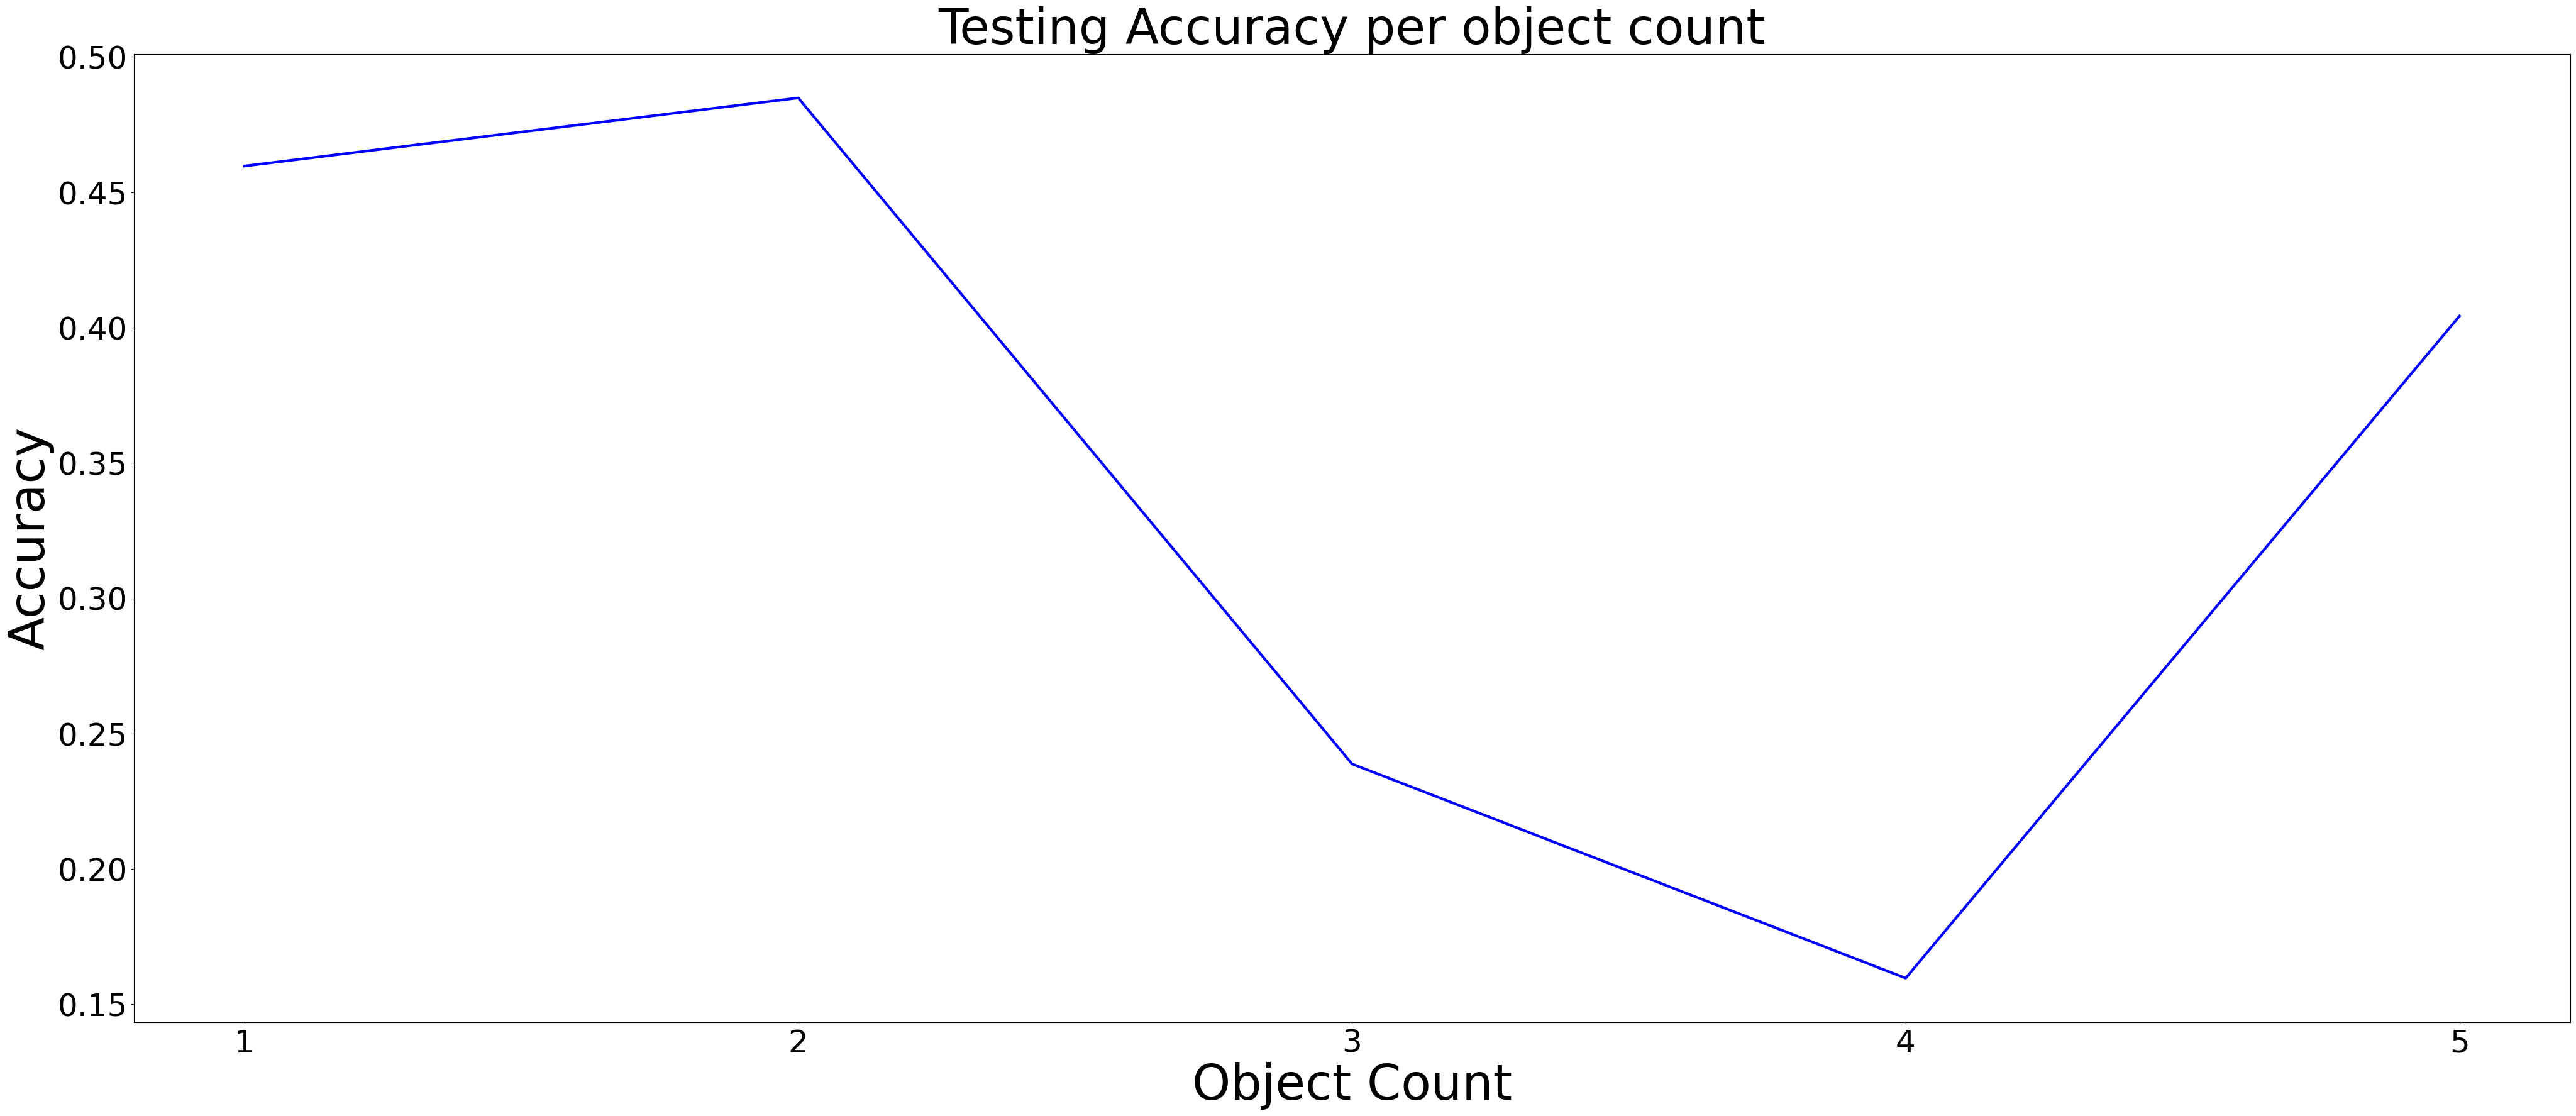

In [135]:
# plot the overall testing accuracies

fontsize = 56

y = list(overall_accuracy.values())
x = list(overall_accuracy.keys())

plt.figure(figsize=(50,20))

plt.plot(x, y, color='blue', linewidth=3)

plt.title('Testing Accuracy per object count', fontsize=fontsize)
plt.xlabel('Object Count', fontsize=fontsize)
plt.ylabel('Accuracy', fontsize=fontsize)
plt.tick_params(axis="both", labelsize=36)

plt.show()

## Standout Suggestions
You do not need to perform the tasks below to finish your project. However, you can attempt these tasks to turn your project into a more advanced portfolio piece.

### Hyperparameter Tuning
**TODO:** Here you can perform hyperparameter tuning to increase the performance of your model. You are encouraged to 
- tune as many hyperparameters as you can to get the best performance from your model
- explain why you chose to tune those particular hyperparameters and the ranges.


In [ ]:
#TODO: Create your hyperparameter search space



In [ ]:
#TODO: Create your training estimator

In [ ]:
# TODO: Fit your estimator

In [ ]:
# TODO: Find the best hyperparameters

### Model Profiling and Debugging
**TODO:** Use model debugging and profiling to better monitor and debug your model training job.

In [ ]:
# TODO: Set up debugging and profiling rules and hooks

In [ ]:
# TODO: Create and fit an estimator

In [ ]:
# TODO: Plot a debugging output.

**TODO**: Is there some anomalous behaviour in your debugging output? If so, what is the error and how will you fix it?  
**TODO**: If not, suppose there was an error. What would that error look like and how would you have fixed it?

In [ ]:
# TODO: Display the profiler output

### Model Deploying and Querying
**TODO:** Can you deploy your model to an endpoint and then query that endpoint to get a result?

In [ ]:
# TODO: Deploy your model to an endpoint

In [ ]:
# TODO: Run an prediction on the endpoint

In [ ]:
# TODO: Remember to shutdown/delete your endpoint once your work is done

### Cheaper Training and Cost Analysis
**TODO:** Can you perform a cost analysis of your system and then use spot instances to lessen your model training cost?

In [ ]:
# TODO: Cost Analysis

In [ ]:
# TODO: Train your model using a spot instance

### Multi-Instance Training
**TODO:** Can you train your model on multiple instances?

In [ ]:
# TODO: Train your model on Multiple Instances